In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
%matplotlib inline

In [2]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Utils.DataReader import load_urm, load_target

In [3]:
URM_all = load_urm()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.85)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 12040 (28.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 10186 (24.5%) Users that have less than 1 test interactions


## Item Based Collaborative Filtering

In [4]:
item_id = 100
shrink = 10

numerator_vector = URM_train.T[item_id].dot(URM_train).toarray().ravel()
numerator_vector

array([0., 0., 0., ..., 1., 0., 0.])

In [5]:
item_norms = np.sqrt(np.array(URM_train.power(2).sum(axis=0))).ravel()
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6

similarity_vector = numerator_vector/denominator_vector
similarity_vector

array([0.        , 0.        , 0.        , ..., 0.01767978, 0.        ,
       0.        ])

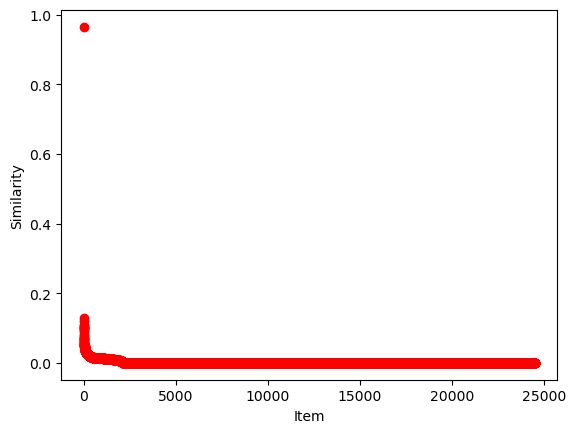

In [6]:
sorted_item_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

In [7]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train, shrink=100,
                                              topK=50, normalize=True,
                                              similarity = "cosine")

W_sparse = similarity_object.compute_similarity()

Similarity column 24507 (100.0%), 892.93 column/sec. Elapsed time 27.45 sec


In [8]:
user_id = 100

user_profile = URM_train[user_id]
scores = user_profile.dot(W_sparse).toarray().ravel()

ranking = scores.argsort()[::-1]

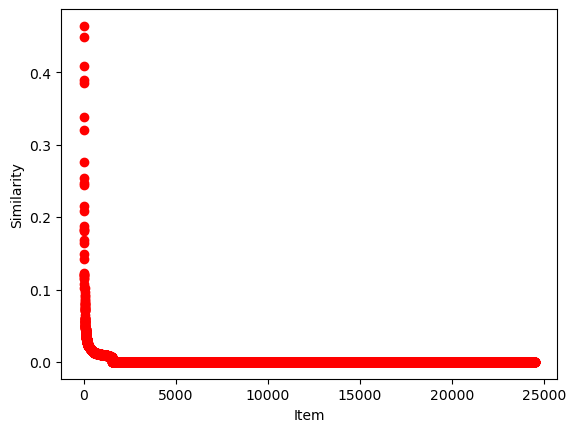

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

In [10]:
ranking[0:10]

array([ 385,  537,  773,  775,  153,  826,  555,  545,  993, 1108],
      dtype=int64)

## Let's create the Recommender

In [11]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCFRecommender(object):

    def __init__(self, URM):
        self.URM = URM


    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):

        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink,
                                                      topK=topK, normalize=normalize,
                                                      similarity = similarity)

        self.W_sparse = similarity_object.compute_similarity()


    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

## Testing the Recommender

In [12]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=50.0, topK=100)

Similarity column 24507 (100.0%), 875.30 column/sec. Elapsed time 28.00 sec


## Evaluation - Hyperparameter Tuning

### Number of neighbors

In [13]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 244 ( 0.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 11700 (47.7%) items with no interactions.
Similarity column 24507 (100.0%), 5012.42 column/sec. Elapsed time 4.89 sec
EvaluatorHoldout: Processed 29589 (100.0%) in 22.82 sec. Users per second: 1297
ItemKNNCFRecommender: URM Detected 244 ( 0.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 11700 (47.7%) items with no interactions.
Similarity column 24507 (100.0%), 5373.49 column/sec. Elapsed time 4.56 sec
EvaluatorHoldout: Processed 29589 (100.0%) in 25.09 sec. Users per second: 1179
ItemKNNCFRecommender: URM Detected 244 ( 0.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 11700 (47.7%) items with no interactions.
Similarity column 24507 (100.0%), 4597.89 column/sec. Elapsed time 5.33 sec
EvaluatorHoldout: Processed 29589 (100.0%) in 27.48 sec. Users per second: 1077
ItemKNNCFRecommender: URM Detected 244 ( 0.6%) users with no interactions.
I

In [14]:
result_df

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.025577,0.098832,0.098704,0.011284,0.043311,0.09162,0.06975,0.040627,0.206529,0.101501,...,0.710779,0.146797,0.710779,0.057455,9.752435,0.994885,0.278842,0.806008,2.156746,1.053334


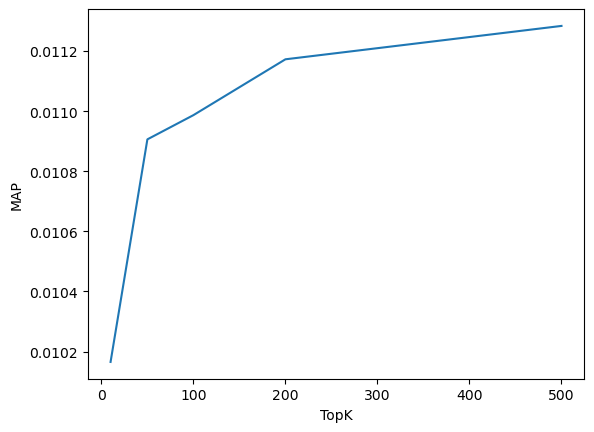

In [15]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

### Shrinkage

In [16]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 244 ( 0.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 11700 (47.7%) items with no interactions.
Similarity column 24507 (100.0%), 4836.93 column/sec. Elapsed time 5.07 sec
EvaluatorHoldout: Processed 29589 (100.0%) in 27.26 sec. Users per second: 1085
ItemKNNCFRecommender: URM Detected 244 ( 0.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 11700 (47.7%) items with no interactions.
Similarity column 24507 (100.0%), 5121.52 column/sec. Elapsed time 4.79 sec
EvaluatorHoldout: Processed 29589 (100.0%) in 26.92 sec. Users per second: 1099
ItemKNNCFRecommender: URM Detected 244 ( 0.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 11700 (47.7%) items with no interactions.
Similarity column 24507 (100.0%), 5175.94 column/sec. Elapsed time 4.73 sec
EvaluatorHoldout: Processed 29589 (100.0%) in 27.97 sec. Users per second: 1058
ItemKNNCFRecommender: URM Detected 244 ( 0.6%) users with no interactions.
I

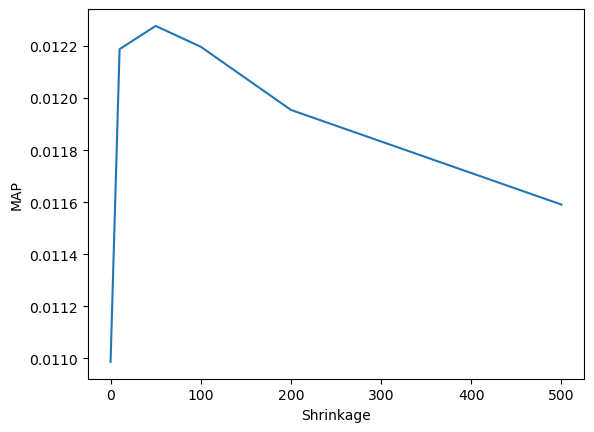

In [17]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

## Submissions

In [21]:
test_users = pd.read_csv('Dataset/data_target_users_test.csv')

In [22]:
user_id = test_users['user_id']
recommendations = []
for user in user_id:
    recommendations.append(recommender.recommend(user, cutoff=10))

In [24]:
for index in range(len(recommendations)):
    recommendations[index]=np.array(recommendations[index])

test_users['item_list']= recommendations
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])
test_users.to_csv('Submissions\Submission_ItemKNN_URM_views_clicks.csv', index=False)